In [1]:
import bilby
import numpy as np
import matplotlib.pylab as plt
import json
import os

In [70]:
ra = 1.7
dec = 1.7
pol = 0.2
inc = np.pi/6 #np.pi/2
time = 1000000000
t12=0.01
phi=0.
injection_parameters = {'mass_1': 30.0, 'mass_2': 30.0, 'luminosity_distance': 5*400., 'psi': pol, 'theta_jn': inc, \
                        'phase': 0, 'geocent_time': time, 'ra': ra, 'dec': dec,'t12': t12,'lens_angle': phi}
            

In [71]:
injection_parameters

{'mass_1': 30.0,
 'mass_2': 30.0,
 'luminosity_distance': 2000.0,
 'psi': 0.2,
 'theta_jn': 0.5235987755982988,
 'phase': 0,
 'geocent_time': 1000000000,
 'ra': 1.7,
 'dec': 1.7,
 't12': 0.01,
 'lens_angle': 0.0}

In [72]:
duration = 8.
sampling_frequency = 2048.

# Specify the output directory and the name of the simulation.
outdir = 'outdir'
label = 'test'
bilby.core.utils.setup_logger(outdir=outdir, label=label)

In [73]:
# Fixed arguments passed into the source model
waveform_arguments = dict(waveform_approximant='IMRPhenomPv2',
                          reference_frequency=20., minimum_frequency=20.)

In [74]:
def pol_model(frequency_array,mass_1, mass_2, luminosity_distance,theta_jn,phase,t12=0.,lens_angle = 0):
    
    waveform_polarizations = bilby.gw.source.lal_binary_black_hole(frequency_array,mass_1=mass_1,mass_2=mass_2,luminosity_distance=luminosity_distance, theta_jn=theta_jn, phase=phase,a_1=0, a_2=0, tilt_1=0, tilt_2=0,\
                                                                   phi_12=0,phi_jl=0,waveform_arguments =waveform_arguments)
    Delta=np.exp(2j*frequency_array*2*np.pi*t12) ##error!!
    hp, hc =waveform_polarizations['plus'], waveform_polarizations['cross']
    
    waveform_polarizations['plus'] *= 1/2.*((Delta-1.)*np.cos(4*lens_angle)+Delta+1)
    waveform_polarizations['plus'] += 1/2.*(Delta-1.)*np.sin(4.*lens_angle)*hc
    waveform_polarizations['cross'] *= 1/2.*(-(Delta-1.)*np.cos(4*lens_angle)+Delta+1)
    waveform_polarizations['cross'] += 1/2.*(Delta-1.)*np.sin(4.*lens_angle)*hp
        
    return waveform_polarizations

In [75]:
#frequency_array=np.arange(20.,1000.,1./2048)

#waveform_polarizations = bilby.gw.source.lal_binary_black_hole(frequency_array,mass_1=mass_1,mass_2=mass_2,luminosity_distance=luminosity_distance, theta_jn=theta_jn, phase=phase,a_1=0, a_2=0, tilt_1=0, tilt_2=0,\
                                                             #      phi_12=0,phi_jl=0,waveform_arguments =waveform_arguments)

In [76]:
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=pol_model)#bilby.gw.source.pol_model

02:33 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: __main__.pol_model
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


# check the waveforms with different t12 values

In [77]:
ifos1 = bilby.gw.detector.InterferometerList(['H1', 'L1','V1'])
ifos2 = bilby.gw.detector.InterferometerList(['H1', 'L1','V1'])
ifos3 = bilby.gw.detector.InterferometerList(['H1', 'L1','V1'])


ifos1.set_strain_data_from_zero_noise(sampling_frequency=sampling_frequency, duration=duration,
   start_time=injection_parameters['geocent_time'] - 6)
ifos2.set_strain_data_from_zero_noise(sampling_frequency=sampling_frequency, duration=duration,
   start_time=injection_parameters['geocent_time'] - 6)
ifos3.set_strain_data_from_zero_noise(sampling_frequency=sampling_frequency, duration=duration,
   start_time=injection_parameters['geocent_time'] - 6)

injection_parameters['t12']=0
injection_0 = ifos1.inject_signal(waveform_generator=waveform_generator,parameters=injection_parameters)
injection_parameters['t12']=-0.03
injection_001 = ifos2.inject_signal(waveform_generator=waveform_generator,parameters=injection_parameters)
injection_parameters['t12']=-0.03
injection_parameters['lens_angle'] = np.pi/5.
injection_01 = ifos3.inject_signal(waveform_generator=waveform_generator,parameters=injection_parameters)

02:33 bilby INFO    : Injected signal in H1:
02:33 bilby INFO    :   optimal SNR = 12.64
02:33 bilby INFO    :   matched filter SNR = 12.64+0.00j
02:33 bilby INFO    :   mass_1 = 30.0
02:33 bilby INFO    :   mass_2 = 30.0
02:33 bilby INFO    :   luminosity_distance = 2000.0
02:33 bilby INFO    :   psi = 0.2
02:33 bilby INFO    :   theta_jn = 0.5235987755982988
02:33 bilby INFO    :   phase = 0
02:33 bilby INFO    :   geocent_time = 1000000000
02:33 bilby INFO    :   ra = 1.7
02:33 bilby INFO    :   dec = 1.7
02:33 bilby INFO    :   t12 = 0
02:33 bilby INFO    :   lens_angle = 0.0
02:33 bilby INFO    : Injected signal in L1:
02:33 bilby INFO    :   optimal SNR = 10.48
02:33 bilby INFO    :   matched filter SNR = 10.48+0.00j
02:33 bilby INFO    :   mass_1 = 30.0
02:33 bilby INFO    :   mass_2 = 30.0
02:33 bilby INFO    :   luminosity_distance = 2000.0
02:33 bilby INFO    :   psi = 0.2
02:33 bilby INFO    :   theta_jn = 0.5235987755982988
02:33 bilby INFO    :   phase = 0
02:33 bilby INFO

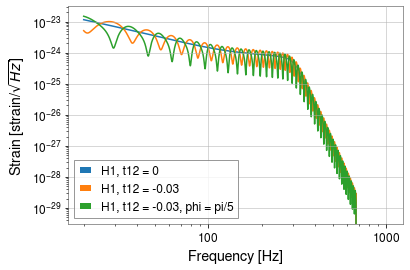

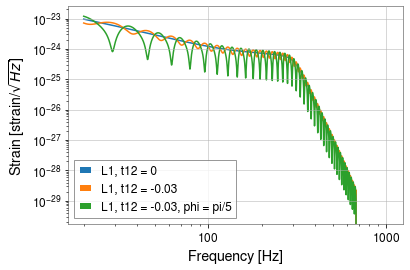

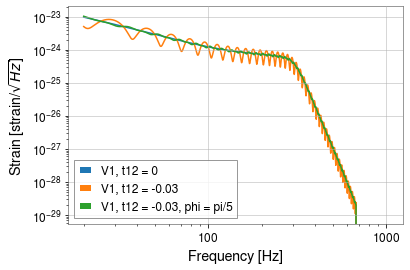

In [80]:

for i in [0,1,2]:
    fig, ax = plt.subplots()

    det = ifos1[i]

    idxs = det.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
    ax.loglog(det.strain_data.frequency_array[idxs],
              np.abs(det.strain_data.frequency_domain_strain[idxs]),
              label=str(det.name)+ ', t12 = 0')
   
    det = ifos2[i]

    idxs = det.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
    ax.loglog(det.strain_data.frequency_array[idxs],
              np.abs(det.strain_data.frequency_domain_strain[idxs]),
              label=str(det.name) + ', t12 = -0.03')
    
    det = ifos3[i]

    idxs = det.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
    ax.loglog(det.strain_data.frequency_array[idxs],
              np.abs(det.strain_data.frequency_domain_strain[idxs]),
              label=str(det.name) + ', t12 = -0.03, phi = pi/5')

    ax.set_xlabel("Frequency [Hz]")
    ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
    ax.legend()
    plt.show()


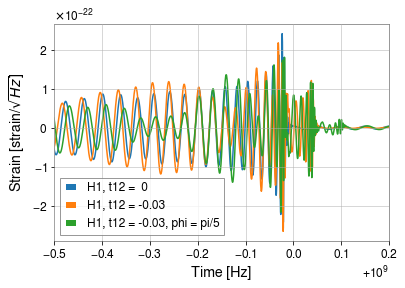

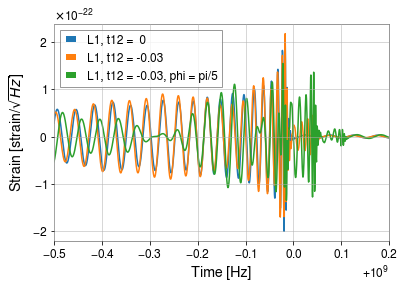

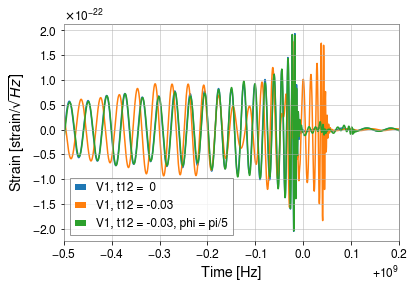

In [81]:

for i in [0,1,2]:
    fig, ax = plt.subplots()

    det = ifos1[i]

    ax.plot(det.strain_data.time_array,
              det.strain_data.time_domain_strain,
              label=str(det.name)+ ', t12 =  0')
   
    det = ifos2[i]

    ax.plot(det.strain_data.time_array,
              det.strain_data.time_domain_strain,
              label=str(det.name)+ ', t12 = -0.03')
    
    det = ifos3[i]

    ax.plot(det.strain_data.time_array,
              det.strain_data.time_domain_strain,
              label=str(det.name)+ ', t12 = -0.03, phi = pi/5')
    
    ax.set_xlabel("Time [Hz]")
    ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
    gps_time= injection_parameters['geocent_time']
    ax.set_xlim(gps_time - 0.5, gps_time + 0.2)
    ax.legend()
    plt.show()


# PE bilby(don't run unless checking)

In [45]:
priors = bilby.gw.prior.BBHPriorDict()
del priors['chirp_mass']
del priors['mass_ratio']
priors['geocent_time'] = bilby.core.prior.Uniform(
    minimum=injection_parameters['geocent_time'] - 1,
    maximum=injection_parameters['geocent_time'] + 1,
    name='geocent_time', latex_label='$t_c$', unit='$s$')
priors['mass_1'] = bilby.core.prior.Uniform(20,40,name='mass_1', latex_label='$m_1$', unit='$Msol$')
priors['mass_2'] = bilby.core.prior.Uniform(20,40,name='mass_2', latex_label='$m_1$', unit='$Msol$')
for key in ['a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl']:
    priors[key] = 0
priors['t12']=bilby.core.prior.Uniform(-1,1,name='Delta t_12', latex_label='$\Delta t_{12}$', unit='$Msol$')
priors['lens_angle']=bilby.core.prior.Uniform(0,np.pi,name='lens angle', latex_label='$\Phi_{lens}$', unit='$rad$')


02:27 bilby INFO    : No prior given, using default BBH priors in /home1/srashti.goyal/anaconda3/envs/bilby_env/lib/python3.7/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [ ]:
# Initialise the likelihood by passing in the interferometer data (ifos) and
# the waveform generator
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos1, waveform_generator=waveform_generator)

# Run sampler.  In this case we're going to use the `dynesty` sampler
result = bilby.run_sampler(
    likelihood=likelihood, priors=priors, sampler='dynesty', npoints=1000,
    injection_parameters=injection_parameters, outdir=outdir, label=label)

# Make a corner plot.
result.plot_corner()